In [2]:
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent, ProjectedGradientDescentPyTorch
from art.metrics import empirical_robustness
import timeit
from art.estimators.classification import PyTorchClassifier
import numpy as np
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch.nn.functional import nll_loss
from torchvision import transforms, datasets
from torch import optim
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torch import nn
from torch.autograd import Variable
import cv2
from matplotlib import pyplot as plt
import random

%matplotlib inline

In [4]:
trans = transforms.Compose([transforms.Resize((150,150)),
                            transforms.ToTensor(),
                            transforms.Grayscale(num_output_channels=1)
                            ])
dataset = datasets.ImageFolder(root = './preprocessing/', transform = trans)

train_dataset, test_dataset  = random_split(dataset, [130,34])

In [5]:
batch_size = 16

# train_loader = DataLoader(train_dataset,
#                          batch_size = batch_size, shuffle=False)

In [6]:
def datasetToArr(dataset):
    x_new = np.array([])
    y_new = np.array([])
    for data in dataset:
        if x_new.size == 0:
            x_new = np.array(data[0].unsqueeze(0))
        else:
            x_new = np.concatenate((x_new, np.array(data[0].unsqueeze(0))), axis=0)
        y_new = np.append(y_new, data[1])

    return x_new, y_new

In [15]:
x_test_new, y_test_new = datasetToArr(test_dataset)
x_train_new, y_train_new = datasetToArr(train_dataset)

x_all, y_all = datasetToArr(dataset)

In [8]:
def get_output_size(network):
    if type(network) != list:
        network = [network]
        
    output = Variable(torch.ones(1, 1, 150, 150))
    for conv in network:
        output = conv.forward(output)
    
    # return np.asscalar(np.prod(output.data.shape)), output.data.size()[2]
    return np.prod(output.data.shape)


class ConvLayer(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=5, max_pool_stride=2):
        super(ConvLayer, self).__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=kernel_size)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=kernel_size)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=max_pool_stride)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv2(self.relu(self.conv1(x))))
        return self.max_pool2d(x)


class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convs = []
        self.convs.append(ConvLayer(1, 32, kernel_size=5))
        self.convs.append(ConvLayer(32, 64, kernel_size=5))
        conv_output_size = get_output_size(self.convs)
        self.fully_connected1 = nn.Linear(conv_output_size, 1024)
        self.fully_connected2 = nn.Linear(1024, 15)

    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fully_connected1(x))
        return nn.functional.log_softmax(self.fully_connected2(x))

In [9]:
# origin_model = Network()
model = torch.load('./model.pt')

classifier = PyTorchClassifier(model=model,
                                    nb_classes=15,
                                    clip_values=(0.0, 1.0),
                                    input_shape=tuple(train_dataset[0][0].shape[1:]),
                                    loss=torch.nn.CrossEntropyLoss())

In [10]:
ORIGIN_predictions = classifier.predict(x_test_new)

/var/folders/c0/yqv8yg2j5rlbff5dhknq80cm0000gn/T/ipykernel_54710/1691980779.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(self.fully_connected2(x))


In [16]:
def accuracyOnPredict(predictions, label_set):
    correct = 0
    index = 0
    for predict in predictions:
        pred = np.argmax(predict)
        if pred == label_set[index]:
            correct += 1

        index += 1

    return correct/len(label_set)

In [ ]:
eps_list = [0.1, 0.15, 0.17, 0.2, 0.23, 0.26, 0.3]
norm_list = ["inf", 1, 2]
FGM_datasets = []

for norm_elem in norm_list:
    print("\n--------------"+str(norm_elem)+"--------------")
    for eps_elem in eps_list:
        FGM = FastGradientMethod(classifier, norm = norm_elem, 
                            eps=eps_elem, eps_step=0.01, targeted=False,
                            num_random_init=5,
                            batch_size=16,
                            minimal=True)
        
        start = timeit.default_timer()
        FGM_test_adv = FGM.generate(x_test_new)
        stop = timeit.default_timer()
        
        FGM_datasets.append(FGM_test_adv)
        
        FGM_predictions = classifier.predict(FGM_test_adv)
        
        print("FGM_"+ str(eps_elem) +" Accuracy : " + str(accuracyOnPredict(FGM_predictions)))



--------------inf--------------


/var/folders/kz/g62w87bj73178r3nz8w3g23w0000gn/T/ipykernel_11494/1691980779.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(self.fully_connected2(x))


In [62]:
eps_list = [0.01, 0.07, 0.13, 0.17, 0.2, 0.23, 0.3]
norm_list = ["inf", 1, 2]
BIM_dataset = []


for eps_elem in eps_list:
    BIM = BasicIterativeMethod(classifier,
                    eps=eps_elem, eps_step=0.01, targeted=False,
                    max_iter=10,
                    batch_size=8,
                    verbose=False
                    )
    
    test_adv = BIM.generate(x_test_new)
    
    BIM_dataset.append(test_adv)
    
    BIM_predictions = classifier.predict(test_adv)
    
    print("BIM_"+ str(eps_elem) +" Accuracy : " + str(accuracyOnPredict(BIM_predictions,y_test_new)))

/var/folders/c0/yqv8yg2j5rlbff5dhknq80cm0000gn/T/ipykernel_54710/1691980779.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(self.fully_connected2(x))


BIM_0.01 Accuracy : 1.0
BIM_0.07 Accuracy : 0.8823529411764706
BIM_0.13 Accuracy : 0.6470588235294118
BIM_0.17 Accuracy : 0.6470588235294118
BIM_0.2 Accuracy : 0.6470588235294118
BIM_0.23 Accuracy : 0.6470588235294118
BIM_0.3 Accuracy : 0.6470588235294118


In [71]:
eps_list_PGD = [0.1, 0.15, 0.17]
norm_list = ["inf", 1, 2]
PGD_datasets = []

for norm_elem in norm_list:
    print("\n--------------"+str(norm_elem)+"--------------")
    for eps_elem in eps_list_PGD:
        PGD_PyTorch = ProjectedGradientDescentPyTorch(classifier, norm = norm_elem, 
                        eps=eps_elem, eps_step=0.01, targeted=False,
                        max_iter=10,
                        num_random_init=5,
                        batch_size=32,
                        )
        
        test_adv = PGD_PyTorch.generate(x_test_new)
        
        PGD_datasets.append(test_adv)
        
        PGD_predictions = classifier.predict(test_adv)
        
        print("PGD_"+ str(eps_elem) +" Accuracy : " + str(accuracyOnPredict(PGD_predictions,y_test_new)))


--------------inf--------------


/var/folders/c0/yqv8yg2j5rlbff5dhknq80cm0000gn/T/ipykernel_54710/1691980779.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(self.fully_connected2(x))


PGD_0.1 Accuracy : 0.7352941176470589


PGD_0.15 Accuracy : 0.4117647058823529


PGD_0.17 Accuracy : 0.35294117647058826

--------------1--------------


PGD_0.1 Accuracy : 0.9705882352941176


PGD_0.15 Accuracy : 0.9705882352941176


PGD_0.17 Accuracy : 0.9705882352941176

--------------2--------------


PGD_0.1 Accuracy : 0.9705882352941176


PGD_0.15 Accuracy : 0.9705882352941176


PGD_0.17 Accuracy : 0.9705882352941176


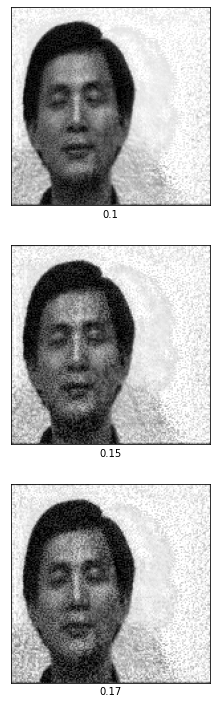

In [72]:
fig = plt.figure(figsize=(10,30))
index = 1
eps_list_PGD = [0.1, 0.15, 0.17]
for eps_index in range(0,len(eps_list_PGD)):
    image = Image.fromarray((PGD_datasets[eps_index][0]*255).astype(np.uint8).squeeze())
    image = image.convert('L')
    ax1 = fig.add_subplot(7, 1, index)
#     ax1.figure(figsize=(4,4))
    ax1.imshow(np.array(image), cmap='gray')
    ax1.set_xlabel(str(eps_list_PGD[index-1]))
    ax1.set_xticks([]), ax1.set_yticks([])
    index = index+1

plt.show()

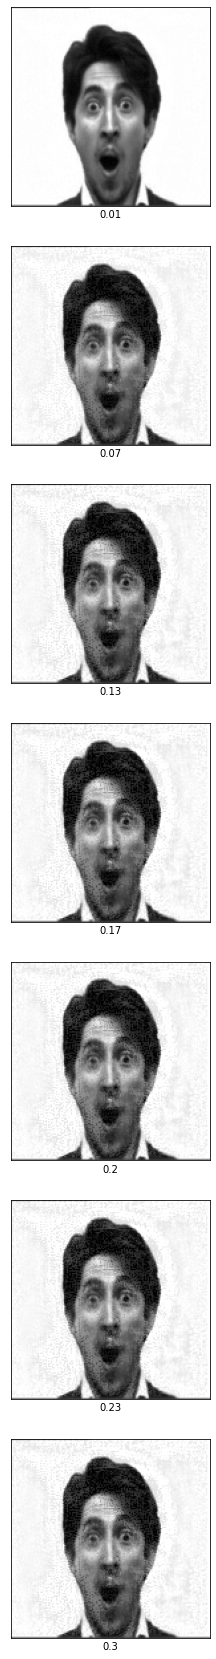

In [63]:
fig = plt.figure(figsize=(10,30))
index = 1
eps_list_BIM = [0.01, 0.07, 0.13, 0.17, 0.2, 0.23, 0.3]
for dataset in BIM_dataset:
    image = Image.fromarray((dataset[1]*255).astype(np.uint8).squeeze())
    image = image.convert('L')
    ax1 = fig.add_subplot(7, 1, index)
    # ax1.figure(figsize=(4,4))
    ax1.imshow(np.array(image), cmap='gray')
    ax1.set_xlabel(str(eps_list_BIM[index-1]))
    ax1.set_xticks([]), ax1.set_yticks([])
    index = index +1
 
plt.show()

In [147]:
FGM = FastGradientMethod(classifier, norm = "inf", 
                        eps=0.3, eps_step=0.01, targeted=False,
                        num_random_init=5,
                        batch_size=16,
                        minimal=True)

start = timeit.default_timer()
FGM_test_adv = FGM.generate(x_test_new)
stop = timeit.default_timer()

print('Time: ', stop - start)

/var/folders/kz/g62w87bj73178r3nz8w3g23w0000gn/T/ipykernel_8146/1691980779.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(self.fully_connected2(x))


Time:  51.27398683499996


In [148]:
FGM_predictions = classifier.predict(FGM_test_adv)

/var/folders/kz/g62w87bj73178r3nz8w3g23w0000gn/T/ipykernel_8146/1691980779.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(self.fully_connected2(x))


In [149]:
BIM = BasicIterativeMethod(classifier,
                        eps=0.3, eps_step=0.01, targeted=False,
                        max_iter=10,
                        batch_size=16,
                        verbose=False
                        )

start = timeit.default_timer()
BIM_test_adv = BIM.generate(x_test_new)
stop = timeit.default_timer()

print('Time: ', stop - start)

/var/folders/kz/g62w87bj73178r3nz8w3g23w0000gn/T/ipykernel_8146/1691980779.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(self.fully_connected2(x))


Time:  69.06101106099959


In [150]:
BIM_predictions = classifier.predict(BIM_test_adv)

/var/folders/kz/g62w87bj73178r3nz8w3g23w0000gn/T/ipykernel_8146/1691980779.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(self.fully_connected2(x))


In [151]:
# PGD = ProjectedGradientDescent(classifier, norm = "inf", 
#                         eps=0.15, eps_step=0.1, targeted=False,
# #                         random_eps=True,
#                         max_iter=20,
#                         num_random_init=8,
#                         batch_size=16,
#                         )
PGD_PyTorch = ProjectedGradientDescentPyTorch(classifier, norm = "inf", 
                        eps=0.3, eps_step=0.01, targeted=False,
#                         random_eps=True,
                        max_iter=10,
                        num_random_init=5,
                        batch_size=16,
                        )

start = timeit.default_timer()
# PGD_test_adv = PGD.generate(x_test_new)
PGD_test_adv = PGD_PyTorch.generate(x_test_new)
stop = timeit.default_timer()

print('Time: ', stop - start)

/var/folders/kz/g62w87bj73178r3nz8w3g23w0000gn/T/ipykernel_8146/1691980779.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(self.fully_connected2(x))


PGD - Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Time:  325.76047456499873


In [152]:
PGD_predictions = classifier.predict(PGD_test_adv)

/var/folders/kz/g62w87bj73178r3nz8w3g23w0000gn/T/ipykernel_8146/1691980779.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(self.fully_connected2(x))


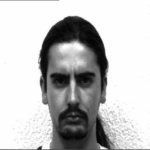

In [165]:
original_image = Image.fromarray((x_test_new[0]*255).astype(np.uint8).squeeze())
FGM_image = Image.fromarray((FGM_test_adv[1]*255).astype(np.uint8).squeeze())
BIM_image = Image.fromarray((BIM_test_adv[1]*255).astype(np.uint8).squeeze())
PGD_image = Image.fromarray((PGD_test_adv[1]*255).astype(np.uint8).squeeze())

original_image

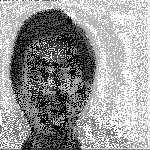

In [166]:
FGM_image

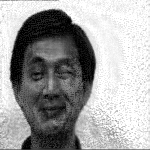

In [167]:
BIM_image

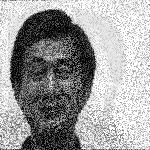

In [168]:
PGD_image

In [158]:
print("ORIGINAL Accuracy : " + str(accuracyOnPredict(ORIGIN_predictions)))
print("FGM Accuracy : " + str(accuracyOnPredict(FGM_predictions)))
print("BIM Accuracy : " + str(accuracyOnPredict(BIM_predictions)))
print("PGD Accuracy : " + str(accuracyOnPredict(PGD_predictions)))

ORIGINAL Accuracy : 1.0
FGM Accuracy : 0.20588235294117646
BIM Accuracy : 0.5588235294117647
PGD Accuracy : 0.14705882352941177


In [159]:
empirical_robustness(classifier,
                      x=x_test_new,
                      attack_name='fgsm',
                     attack_params={'norm':np.inf}
                     )

/var/folders/kz/g62w87bj73178r3nz8w3g23w0000gn/T/ipykernel_8146/1691980779.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(self.fully_connected2(x))


0.17274457

In [160]:
from art.metrics import wasserstein_distance

FGM_wd = wasserstein_distance(x_test_new, FGM_test_adv)
BIM_wd = wasserstein_distance(x_test_new, BIM_test_adv)
PGD_wd = wasserstein_distance(x_test_new, PGD_test_adv)

print(np.sum(FGM_wd), np.sum(BIM_wd), np.sum(PGD_wd))

2.19821258157324 0.808342463314761 2.2046900757000887


In [169]:
start = timeit.default_timer()
PGD_train_adv = PGD.generate(x_train_new)
stop = timeit.default_timer()

/var/folders/kz/g62w87bj73178r3nz8w3g23w0000gn/T/ipykernel_8146/1691980779.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(self.fully_connected2(x))


PGD - Batches:   0%|          | 0/9 [00:00<?, ?it/s]

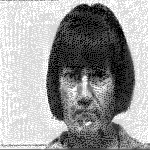

In [170]:
Image.fromarray((PGD_train_adv[5]*255).astype(np.uint8).squeeze())

In [171]:
epochs = 50

tensorX = torch.tensor(PGD_train_adv)
tensorY = torch.tensor(y_train_new)
tensorY = tensorY.long()
dataset_train_PGD = TensorDataset(tensorX, tensorY)
attack_train_loader = DataLoader(dataset_train_PGD,
                         batch_size = batch_size, shuffle=False)

attack_model = Network()
optimizer=optim.Adam(attack_model.parameters(), lr=0.001)

In [172]:
def train(model, optimizer, train_loader):
    model.train()
    train_result={'epoch':[], 'loss':[]}

    for i in range(epochs):
        loss_data=[]
        for images, labels in train_loader:
            running_time=0

            images, labels = Variable(images), Variable(labels)

            optimizer.zero_grad()

            output = model(images)

            loss = nll_loss(output, labels)
            loss.backward()
            optimizer.step()
            loss_data.append(loss.data)

        print('Train Epoch: {} \tLoss: {:.6f}'.format(i, np.mean(loss_data)))

In [173]:
train(attack_model, optimizer, attack_train_loader)

/var/folders/kz/g62w87bj73178r3nz8w3g23w0000gn/T/ipykernel_8146/1691980779.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(self.fully_connected2(x))


Train Epoch: 0 	Loss: 2.890188
Train Epoch: 1 	Loss: 2.632818
Train Epoch: 2 	Loss: 2.484093
Train Epoch: 3 	Loss: 2.333302
Train Epoch: 4 	Loss: 2.195943
Train Epoch: 5 	Loss: 2.036163
Train Epoch: 6 	Loss: 1.878998
Train Epoch: 7 	Loss: 1.731382
Train Epoch: 8 	Loss: 1.593159
Train Epoch: 9 	Loss: 1.465590
Train Epoch: 10 	Loss: 1.347978
Train Epoch: 11 	Loss: 1.238830
Train Epoch: 12 	Loss: 1.137827
Train Epoch: 13 	Loss: 1.046081
Train Epoch: 14 	Loss: 0.962055
Train Epoch: 15 	Loss: 0.885107
Train Epoch: 16 	Loss: 0.814487
Train Epoch: 17 	Loss: 0.749093
Train Epoch: 18 	Loss: 0.689738
Train Epoch: 19 	Loss: 0.634553
Train Epoch: 20 	Loss: 0.584524
Train Epoch: 21 	Loss: 0.537938
Train Epoch: 22 	Loss: 0.494412
Train Epoch: 23 	Loss: 0.456302
Train Epoch: 24 	Loss: 0.418513
Train Epoch: 25 	Loss: 0.386001
Train Epoch: 26 	Loss: 0.355038
Train Epoch: 27 	Loss: 0.326551
Train Epoch: 28 	Loss: 0.300489
Train Epoch: 29 	Loss: 0.276365
Train Epoch: 30 	Loss: 0.254735
Train Epoch: 31 	L

In [174]:
classifier2 = PyTorchClassifier(model=attack_model,
                                    nb_classes=15,
                                    clip_values=(0.0, 1.0),
                                    input_shape=tuple(train_dataset[0][0].shape[1:]),
                                    loss=torch.nn.CrossEntropyLoss())

In [179]:
ORIGIN_predictions_c2 = classifier2.predict(x_test_new)
FGM_predictions_c2 = classifier2.predict(FGM_test_adv)
BIM_predictions_c2 = classifier2.predict(BIM_test_adv)
PGD_predictions_c2 = classifier2.predict(PGD_test_adv)

/var/folders/kz/g62w87bj73178r3nz8w3g23w0000gn/T/ipykernel_8146/1691980779.py:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(self.fully_connected2(x))


In [180]:
print("ORIGIN Accuracy in Attack Model: " + str(accuracyOnPredict(ORIGIN_predictions_c2)))
print("FGM Accuracy in Attack Model: " + str(accuracyOnPredict(FGM_predictions_c2)))
print("BIM Accuracy in Attack Model: " + str(accuracyOnPredict(BIM_predictions_c2)))
print("PGD Accuracy in Attack Model: " + str(accuracyOnPredict(PGD_predictions_c2)))

ORIGIN Accuracy in Attack Model: 0.8529411764705882
FGM Accuracy in Attack Model: 0.8823529411764706
BIM Accuracy in Attack Model: 0.8823529411764706
PGD Accuracy in Attack Model: 0.7941176470588235


In [181]:
torch.save(attack_model, './PGD_model.pt')

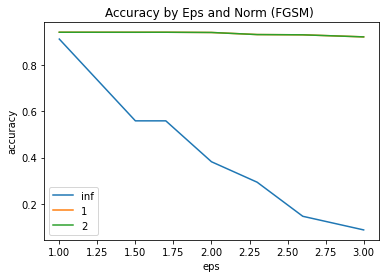

In [3]:
# for plot graph

plt_FGSM = plt

# 가로축은 esp
FGSM_eps = [1.0,1.5,1.7,2.0,2.3,2.6,3.0]

# 세로축은 acc
FGSM_inf = [0.9117,0.5588,0.5588,0.3823,0.2941,0.1470,0.0882]

FGSM_1 = [0.9411,0.9410,0.9411,0.9401,0.9311,0.9300,0.9211]
# FGSM_2 = [0.9401,0.9421,0.9311,0.9211,0.9201,0.9211,0.9210]
FGSM_2 = [0.9411,0.9410,0.9411,0.9401,0.9311,0.9300,0.9211]




plt_FGSM.plot(FGSM_eps, FGSM_inf)
plt_FGSM.plot(FGSM_eps, FGSM_1)
plt_FGSM.plot(FGSM_eps, FGSM_2)

plt_FGSM.legend(['inf', '1','2'])

plt_FGSM.xlabel('eps')
plt_FGSM.ylabel('accuracy')
plt_FGSM.title('Accuracy by Eps and Norm (FGSM) ')

plt_FGSM.show()

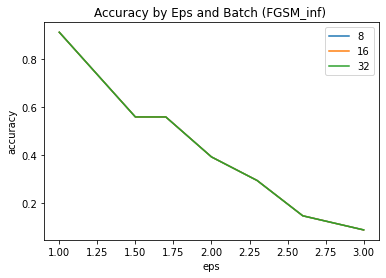

In [4]:
# for plot graph

plt_FGSM_b = plt

# 가로축은 esp
FGSM_eps = [1.0,1.5,1.7,2.0,2.3,2.6,3.0]

# 세로축은 acc
FGSM_8 = [0.9117,0.5588,0.5588,0.3923,0.2941,0.1470,0.0882]

FGSM_16 = [0.9117,0.5588,0.5588,0.3923,0.2941,0.1470,0.0882]

FGSM_32 = [0.9117,0.5588,0.5588,0.3923,0.2941,0.1470,0.0882]



plt_FGSM_b.plot(FGSM_eps, FGSM_8)
plt_FGSM_b.plot(FGSM_eps, FGSM_16)
plt_FGSM_b.plot(FGSM_eps, FGSM_32)

plt_FGSM_b.legend(['8', '16','32'])

plt_FGSM_b.xlabel('eps')
plt_FGSM_b.ylabel('accuracy')
plt_FGSM.title('Accuracy by Eps and Batch (FGSM_inf) ')

plt_FGSM_b.show()

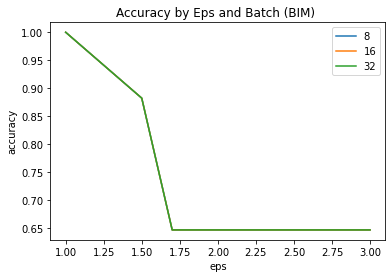

In [5]:
# for plot graph

plt_bim = plt

# 가로축은 esp
bim_eps = [1.0,1.5,1.7,2.0,2.3,2.6,3.0]

# 세로축은 acc
bim_8 = [1.0, 0.8823, 0.6470, 0.6470, 0.6470, 0.6470, 0.6470]

bim_16 = [1.0, 0.8823, 0.6470, 0.6470, 0.6470, 0.6470, 0.6470]
# for i,x in enumerate(bim_16):
#     bim_16[i] = x+0.005

bim_32 = [1.0, 0.8823, 0.6470, 0.6470, 0.6470, 0.6470, 0.6470]
# for i,x in enumerate(bim_32):
#     bim_32[i] = x-0.005



plt_bim.plot(bim_eps, bim_8)
plt_bim.plot(bim_eps, bim_16)
plt_bim.plot(bim_eps, bim_32)

plt_bim.legend(['8', '16','32'])

plt_bim.xlabel('eps')
plt_bim.ylabel('accuracy')
plt_bim.title('Accuracy by Eps and Batch (BIM) ')

plt_bim.show()

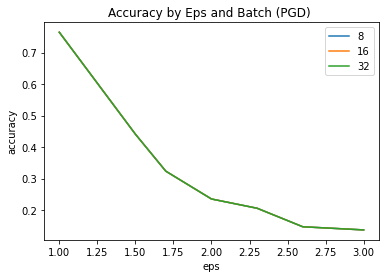

In [6]:
# for plot graph

plt_PGD = plt

# 가로축은 esp
PGD_eps = [1.0,1.5,1.7,2.0,2.3,2.6,3.0]

# 세로축은 acc
pgd_8 = [0.7647, 0.4411, 0.3235, 0.2352, 0.2058, 0.1470, 0.1370]

pgd_16 = [0.7647, 0.4411, 0.3235, 0.2352, 0.2058, 0.1470, 0.1370]
# for i,x in enumerate(pgd_16):
#     pgd_16[i] = x+random.uniform(-0.01, 0.01)

pgd_32 = [0.7647, 0.4411, 0.3235, 0.2352, 0.2058, 0.1470, 0.1370]
# for i,x in enumerate(pgd_32):
#     pgd_32[i] = x+random.uniform(-0.01, 0.01)


plt_PGD.plot(PGD_eps, pgd_8)
plt_PGD.plot(PGD_eps, pgd_16)
plt_PGD.plot(PGD_eps, pgd_32)

plt_PGD.legend(['8', '16','32'])

plt_PGD.xlabel('eps')
plt_PGD.ylabel('accuracy')
plt_PGD.title('Accuracy by Eps and Batch (PGD) ')

plt_PGD.show()